Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lookalike Model completed successfully. Results saved to Lookalike.csv.


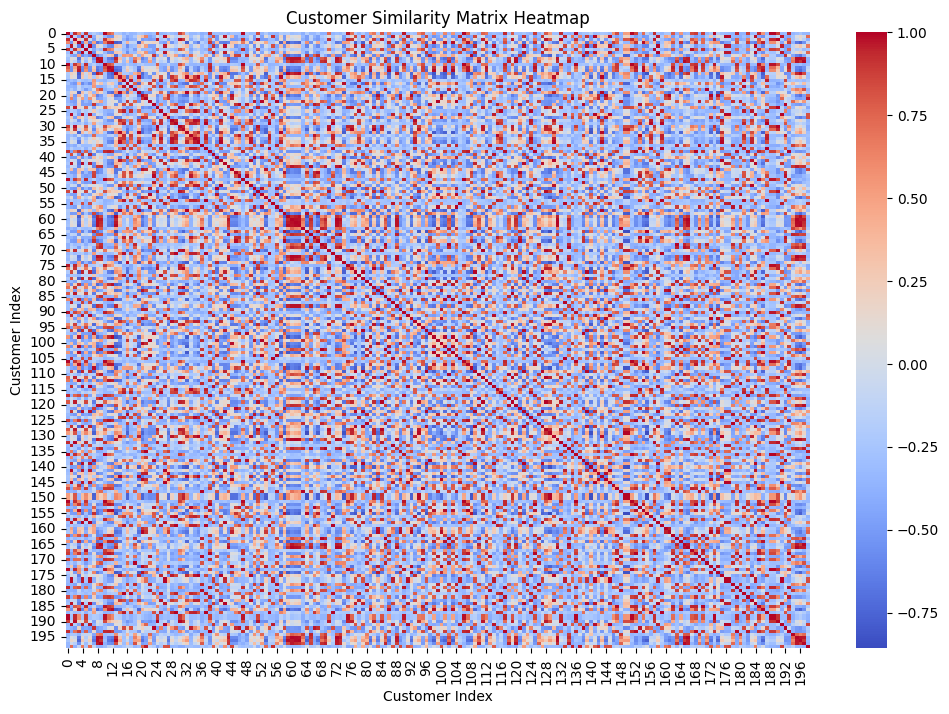

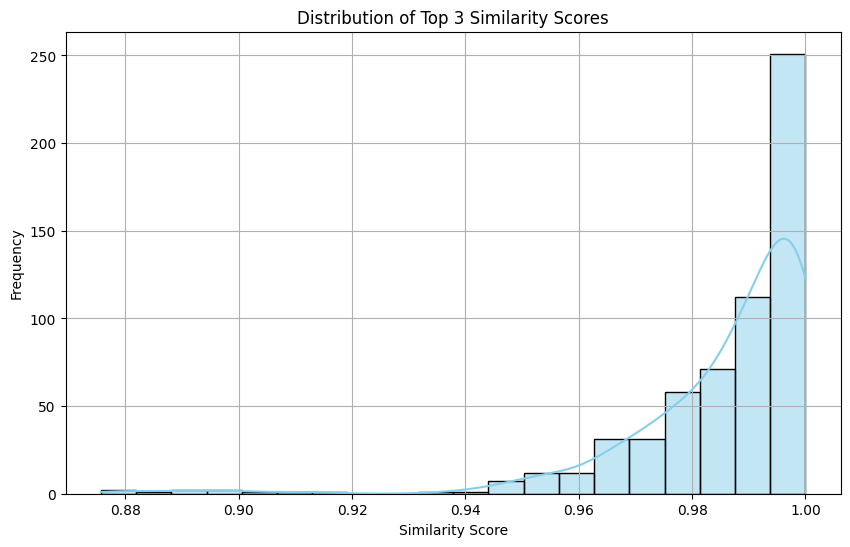

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Load datasets
customers = pd.read_csv('/content/drive/MyDrive/DataScience Intern/Customers.csv')
products = pd.read_csv('/content/drive/MyDrive/DataScience Intern/Products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/DataScience Intern/Transactions.csv')

# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Feature Engineering
# 1. Aggregate customer transaction data
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',                  # Total transaction value
    'ProductID': 'nunique',               # Number of unique products purchased
    'TransactionDate': 'count'            # Number of transactions
}).rename(columns={
    'TotalValue': 'TotalSpend',
    'ProductID': 'UniqueProducts',
    'TransactionDate': 'TransactionCount'
}).reset_index()

# 2. Add demographic information (Region encoded)
region_dummies = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'])
customer_features = customer_features.merge(region_dummies, on='CustomerID')

# Normalize the data for similarity calculation
scaler = StandardScaler()
features_to_normalize = customer_features.drop(columns=['CustomerID']).columns
customer_features[features_to_normalize] = scaler.fit_transform(customer_features[features_to_normalize])

# Compute pairwise cosine similarity
customer_ids = customer_features['CustomerID']
feature_matrix = customer_features.drop(columns=['CustomerID'])
similarity_matrix = cosine_similarity(feature_matrix)

# Create a lookalike map for each customer
lookalike_map = {}
for idx, cust_id in enumerate(customer_ids):
    # Get similarity scores for this customer
    similarity_scores = similarity_matrix[idx]
    # Rank customers by similarity (excluding the customer itself)
    similar_customers = sorted(
        [(customer_ids[i], similarity_scores[i]) for i in range(len(customer_ids)) if i != idx],
        key=lambda x: x[1],
        reverse=True
    )
    # Store the top 3 similar customers
    lookalike_map[cust_id] = similar_customers[:3]

# Create Lookalike.csv for the first 20 customers
top_20_customers = customer_ids[:20]
lookalike_data = {
    'CustomerID': [],
    'Lookalikes': []
}

for cust_id in top_20_customers:
    lookalikes = lookalike_map[cust_id]
    lookalike_data['CustomerID'].append(cust_id)
    lookalike_data['Lookalikes'].append(
        [{'CustomerID': lk[0], 'Score': round(lk[1], 4)} for lk in lookalikes]
    )

lookalike_df = pd.DataFrame(lookalike_data)

# Save the results
lookalike_df.to_csv('/content/drive/MyDrive/DataScience Intern/Lookalike.csv', index=False)

print("Lookalike Model completed successfully. Results saved to Lookalike.csv.")






# Heatmap of the similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap="coolwarm", annot=False, cbar=True)
plt.title("Customer Similarity Matrix Heatmap")
plt.xlabel("Customer Index")
plt.ylabel("Customer Index")
plt.show()

# Extract top 3 similarity scores for each customer
top_3_scores = []
for scores in similarity_matrix:
    top_scores = sorted(scores, reverse=True)[1:4]  # Exclude the self-similarity (1.0)
    top_3_scores.extend(top_scores)

# Histogram of top 3 similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(top_3_scores, bins=20, kde=True, color="skyblue")
plt.title("Distribution of Top 3 Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

